In [ ]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.metrics import accuracy_score,log_loss,precision_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import lightgbm as lgb
import catboost as ctb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Dacon credit-card analysis

https://dacon.io/competitions/official/235713/overview/description/

In [ ]:
SEED = 2021
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# 1. EDA

https://3months.tistory.com/292
## (1) 데이터 불러오기

In [ ]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

#전체적인 시각화와 결측치, 중복값을 보기위해 만든 함수
all_df = pd.concat([train_df, test_df]).reset_index(drop=True)


In [ ]:
print("rows and columns in train set : ", train_df.shape)
print("rows and columns in test set : ", test_df.shape)

rows and columns in train set :  (26457, 20)
rows and columns in test set :  (10000, 19)


In [ ]:
print(train_df.head(5))

   index gender car reality  ...   occyp_type  family_size begin_month credit
0      0      F   N       N  ...          NaN          2.0        -6.0    1.0
1      1      F   N       Y  ...     Laborers          3.0        -5.0    1.0
2      2      M   Y       Y  ...     Managers          2.0       -22.0    2.0
3      3      F   N       Y  ...  Sales staff          2.0       -37.0    0.0
4      4      F   Y       Y  ...     Managers          2.0       -26.0    2.0

[5 rows x 20 columns]


## (2) 데이터 변수 설명

- gender(범주) : 성별 
- car(범주) : 차량 소유 여부
- reality(범주) : 부동산 소유 여부
- child_num(범주): 자녀 수
- income_total(수치) : 연간 소득
- income_type(범주) : 소득 분류
    * 'Commercial associate' :상업 제휴
    * 'Working' : 일반 근무
    * 'State servant' : 공무원
    * 'Pensioner' : 연금 수령자
    * 'Student' : 학생
- edu_type(범주) : 교육 수준
    * 'Higher education' : 고등 교육
    * 'Secondary / secondary special' : 중등 교육?
    * 'Incomplete higher' : 고등학교 중퇴
    * 'Lower secondary'  : 중등교육 아래
    * 'Academic degree' : 학위
- family_type(범주): 결혼 여부
    * 'Married' : 결혼함.
    * 'Civil marriage' : 민사적 결혼? 법률혼
    * 'Separated' : 분리된 가족?
    * 'Single / not married' :싱글
    * 'Widow' : 과부
- house_type(범주) : 생활 방식
    * 'Municipal apartment' : 시립 아파트?LH같은거일듯.
    * 'House / apartment' : 주택/ 아파트
    * 'With parents' : 부모님 집
    * 'Co-op apartment' : 전세같음. https://mentor.heykorean.com/web/qa.php?sno=167848
    * 'Rented apartment' : 빌린 아파트?
    * 'Office apartment' : 회사 아파트
- DAYS_BIRTH(수치) : 출생일. 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미
- DAYS_EMPLOYED(수치) : 업무 시작일. 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미. 양수 값은 고용되지 않은 상태를 의미함

- FLAG_MOBIL(범주): 핸드폰 소유 여부
- work_phone(범주): 업무용 전화 소유 여부
- phone(범주): 전화 소유 여부
- email(범주): 이메일 소유 여부
- occyp_type(범주): 직업 유형
- family_size(범주): 가족 규모
- begin_month(수치): 신용카드 발급 월. 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미


- credit(범주) : 사용자의 신용카드 대금 연체를 기준으로 한 신용도. 낮을수록 높은 신용의 신용카드 사용자를 의미. 상중하(0,1,2)

https://www.dacon.io/competitions/official/235713/talkboard/402821/

## (3) 결측치 갯수 측정

In [ ]:
print('Missing values per columns in train dataset')
for col in train_df.columns:
    temp_col = train_df[col].isnull().sum()
    print(f'{col}: {temp_col}')
print()
print('Missing values per columns in test dataset')
for col in test_df.columns:
    temp_col = test_df[col].isnull().sum()
    print(f'{col}: {temp_col}')

Missing values per columns in train dataset
index: 0
gender: 0
car: 0
reality: 0
child_num: 0
income_total: 0
income_type: 0
edu_type: 0
family_type: 0
house_type: 0
DAYS_BIRTH: 0
DAYS_EMPLOYED: 0
FLAG_MOBIL: 0
work_phone: 0
phone: 0
email: 0
occyp_type: 8171
family_size: 0
begin_month: 0
credit: 0

Missing values per columns in test dataset
index: 0
gender: 0
car: 0
reality: 0
child_num: 0
income_total: 0
income_type: 0
edu_type: 0
family_type: 0
house_type: 0
DAYS_BIRTH: 0
DAYS_EMPLOYED: 0
FLAG_MOBIL: 0
work_phone: 0
phone: 0
email: 0
occyp_type: 3152
family_size: 0
begin_month: 0


In [ ]:
all_df




,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0,NaN
36453,36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0,NaN
36454,36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0,NaN
36455,36455,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0,NaN


In [ ]:
all_df['occyp_type'] = all_df['occyp_type'].fillna('X')


In [ ]:
print(all_df['DAYS_EMPLOYED'])

0        -4709
1        -1540
2        -4434
3        -2092
4        -2105
         ...  
36452    -5434
36453    -1315
36454   -14018
36455    -1085
36456     -187
Name: DAYS_EMPLOYED, Length: 36457, dtype: int64


In [ ]:
Employ_list=all_df['DAYS_EMPLOYED'].unique().tolist()
for i in Employ_list:
    if i>=0: print(i)

365243


In [ ]:
all_df['DAYS_EMPLOYED']=all_df['DAYS_EMPLOYED'].map(lambda x:0 if (x == 365243) else x)


In [ ]:
Employ_list=all_df['DAYS_EMPLOYED'].unique().tolist()
for i in Employ_list:
    if i>=0: print(i)

0


결측치가 존재하는 데이터는 occyp_type.
DAYS_EMPLOYED는 결측치가 없어보이지만 결측치가 365243으로  대체되어있어서 0으로 바꾸어줌.

## (4) 범주형 변수 종류 확인하기



In [ ]:
train_df.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [ ]:
category_feature=['gender', 'car', 'reality', 'child_num', 
                  'edu_type', 'family_type', 'house_type',
                  'FLAG_MOBIL', 'work_phone', 'phone', 'income_type',
                  'email','occyp_type', 'family_size', 'credit']

numeric_feature=['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']

In [ ]:
print(category_feature)
print(numeric_feature)

['gender', 'car', 'reality', 'child_num', 'edu_type', 'family_type', 'house_type', 'FLAG_MOBIL', 'work_phone', 'phone', 'income_type', 'email', 'occyp_type', 'family_size', 'credit']
['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']


In [ ]:
for feature in category_feature:
    print("{}'s unique feature: {}".format(feature,train_df[feature].unique()))
    print()
    

gender's unique feature: ['F' 'M']

car's unique feature: ['N' 'Y']

reality's unique feature: ['N' 'Y']

child_num's unique feature: [ 0  1  2  3  4  5 14 19  7]

edu_type's unique feature: ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

family_type's unique feature: ['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']

house_type's unique feature: ['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']

FLAG_MOBIL's unique feature: [1]

work_phone's unique feature: [0 1]

phone's unique feature: [0 1]

income_type's unique feature: ['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']

email's unique feature: [0 1]

occyp_type's unique feature: [nan 'Laborers' 'Managers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Drivers' 'Medicine staff' 'Accountants' 'Realty agents'
 'Security staff' 'Cleaning staff' 'Private serv

https://m.blog.naver.com/PostView.nhn?blogId=cjh226&logNo=221266237919&proxyReferer=https:%2F%2Fwww.google.com%2F

# ENCODING 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.utils import to_categorical

import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
TARGET='credit'

In [ ]:
# def label_encoder(c):
#     le = LabelEncoder()
#     return le.fit_transform(c)

# def label_test_encoder(c):
#     le = LabelEncoder()
#     return le.transform(c)



scaler = StandardScaler()


In [ ]:
def Simple_lightGBM(x,y):
    X_train, X_valid, y_train, y_valid = train_test_split(x,y,test_size=0.25, random_state=21)

    eval_set = [(X_train, y_train), (X_valid, y_valid)]
    lgbm_model=lgb.LGBMClassifier(objective='multiclass',n_estimators=1000,max_depth=20,)


    lgbm_model.fit(X_train, y_train,early_stopping_rounds=100, eval_metric='logloss',eval_set=eval_set, verbose=True)

    #y_pred=lgbm_model.predict_proba(X_valid)
    #logloss=log_loss(to_categorical(y_valid), y_pred)
    #accuracy=accuracy_score(y_pred, y_test)

    y_pred=lgbm_model.predict(X_valid)

    #preds=lgbm_model.predict(X_valid)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score( y_valid, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    results = lgbm_model.evals_result_
    epochs = len(results['valid_1']['multi_logloss'])
    x_axis = range(0, epochs)
    #print("확인 : ", min(results['valid_1']['multi_logloss']))

    
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['training']['multi_logloss'], label='Train')
    ax.plot(x_axis, results['valid_1']['multi_logloss'], label='Valid')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('LightGBM Log Loss')
    plt.show()

    # y_proba=lgbm_model.predict_proba(X_valid)
    # logloss=log_loss(to_categorical(y_valid), y_proba)
    # print(f"log_loss: {logloss}")

    logloss = min(results['valid_1']['multi_logloss'])



    #pd.DataFrame(preds).apply(lambda x: np.argmax(x), axis=1)


    #print(f"log_loss: {logloss}")
    #print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(preds,y_valid)))
    print()
    lgb.plot_importance(lgbm_model)
    return logloss


In [ ]:

def Some_lightGBM(x,y):
    X_train, X_valid, y_train, y_valid = train_test_split(x,y,test_size=0.25, random_state=21)

    eval_set = [(X_train, y_train), (X_valid, y_valid)]

    lgbm_model=lgb.LGBMClassifier(objective='multiclass',n_estimators=1000,max_depth=20,min_data_in_leaf=300)


    lgbm_model.fit(X_train, y_train,early_stopping_rounds=20, eval_metric='logloss',eval_set=eval_set, verbose=True)

    #y_pred=lgbm_model.predict_proba(X_valid)
    #logloss=log_loss(to_categorical(y_valid), y_pred)
    #accuracy=accuracy_score(y_pred, y_test)

    y_pred=lgbm_model.predict(X_valid)

    #preds=lgbm_model.predict(X_valid)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score( y_valid, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    results = lgbm_model.evals_result_
    epochs = len(results['valid_1']['multi_logloss'])
    x_axis = range(0, epochs)
    #print("확인 : ", min(results['valid_1']['multi_logloss']))

    
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['training']['multi_logloss'], label='Train')
    ax.plot(x_axis, results['valid_1']['multi_logloss'], label='Valid')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('LightGBM Log Loss')
    plt.show()

    # y_proba=lgbm_model.predict_proba(X_valid)
    # logloss=log_loss(to_categorical(y_valid), y_proba)
    # print(f"log_loss: {logloss}")

    logloss = min(results['valid_1']['multi_logloss'])



    #pd.DataFrame(preds).apply(lambda x: np.argmax(x), axis=1)


    #print(f"log_loss: {logloss}")
    #print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(preds,y_valid)))
    print()
    lgb.plot_importance(lgbm_model)
    return logloss


In [ ]:
df_logloss={}

In [ ]:
import copy

In [ ]:
!pip install category_encoders
import category_encoders as ce

# ce_hash=ce.HashingEncoder(cols=['color'])
# ce_hash.fit_transform(X,y)

In [ ]:
# def encode_feature():
#     train_temp = all_df.iloc[:26457, :]#0개~100000개
#     test_temp = all_df.iloc[26457:, :] #100000개~ 

In [ ]:
all_df.columns.drop('index')

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type',
       'family_size', 'begin_month', 'credit'],
      dtype='object')

In [ ]:
list_index=all_df.columns.drop('index')
for i in list_index:
  print("{} : {}".format(i,len(all_df[i].unique())))

gender : 2
car : 2
reality : 2
child_num : 9
income_total : 265
income_type : 5
edu_type : 5
family_type : 5
house_type : 6
DAYS_BIRTH : 7183
DAYS_EMPLOYED : 3640
FLAG_MOBIL : 1
work_phone : 2
phone : 2
email : 2
occyp_type : 19
family_size : 10
begin_month : 61
credit : 4


In [ ]:
all_df.dtypes

index              int64
gender            object
car               object
reality           object
child_num          int64
income_total     float64
income_type       object
edu_type          object
family_type       object
house_type        object
DAYS_BIRTH         int64
DAYS_EMPLOYED      int64
FLAG_MOBIL         int64
work_phone         int64
phone              int64
email              int64
occyp_type        object
family_size      float64
begin_month      float64
credit           float64
dtype: object

In [ ]:
# temp_train=all_df.iloc[:26457, :]
# ce_hash=ce.HashingEncoder(cols=['edu_type','car','occyp_type','house_type',''])
# ce_hash.fit_transform(temp_train)


In [ ]:
# temp_train=all_df.iloc[:26457, :]
# ce_hash2=ce.HashingEncoder(cols=['occyp_type','family_type','house_type'],n_components = 32)
# ce_hash2.fit_transform(temp_train)

In [ ]:
all_df.dtypes

index              int64
gender            object
car               object
reality           object
child_num          int64
income_total     float64
income_type       object
edu_type          object
family_type       object
house_type        object
DAYS_BIRTH         int64
DAYS_EMPLOYED      int64
FLAG_MOBIL         int64
work_phone         int64
phone              int64
email              int64
occyp_type        object
family_size      float64
begin_month      float64
credit           float64
dtype: object

### 변수 삭제

## 전처리

In [ ]:
all_df

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,X,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0,NaN
36453,36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0,NaN
36454,36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0,NaN
36455,36455,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,X,2.0,-33.0,NaN


In [ ]:
#나이 전처리
Age=np.abs(all_df['DAYS_BIRTH'])
Age=np.trunc(Age/(365*5))

all_df['DAYS_BIRTH']=Age

# 고용일자 전처리
Year_Employ=np.abs(all_df['DAYS_EMPLOYED'])
Year_Employ=np.ceil(Year_Employ/3650)
all_df['DAYS_EMPLOYED']=Year_Employ
#all_df['DAYS_EMPLOYED']=np.digitize(all_df['DAYS_EMPLOYED'], bins=[0,1,11])

# 아이 유무 전처리
all_df['child_num']=all_df['child_num'].map(lambda x:1 if (x >0) else 0)


# income_total log 처리 및 범주화
all_df['income_total'] = np.log(all_df['income_total'])
all_df['income_total']=np.digitize(all_df['income_total'], bins=[0,11.5,12.5])

# family size
all_df['family_size']=np.digitize(all_df['family_size'], bins=[0,2,4])

# begin year 발급일 전처리
month=round(np.abs(all_df['begin_month'])/12)
all_df['begin_month']=month



In [ ]:
train_temp = all_df.iloc[:26457, :]#0개~100000개
test_temp = all_df.iloc[26457:, :] #100000개~ 

select_list=['occyp_type','income_total','DAYS_EMPLOYED','DAYS_BIRTH','begin_month']

X_non=train_temp[select_list]
y_non=train_temp['credit']

#test_only=test_temp.drop('credit',axis=1).reset_index(drop=True)


In [ ]:
train_non=pd.concat([X_non,y_non],axis=1)

In [ ]:
list_index=all_df.columns.drop('index')
for i in list_index:
  print("{} : {}".format(i,len(all_df[i].unique())))

gender : 2
car : 2
reality : 2
child_num : 2
income_total : 3
income_type : 5
edu_type : 5
family_type : 5
house_type : 6
DAYS_BIRTH : 10
DAYS_EMPLOYED : 6
FLAG_MOBIL : 1
work_phone : 2
phone : 2
email : 2
occyp_type : 19
family_size : 3
begin_month : 6
credit : 4


In [ ]:
# train_temp = all_df.iloc[:26457, :]#0개~100000개
# test_temp = all_df.iloc[26457:, :] #100000개~ 

# select_list=['occyp_type','income_total','DAYS_EMPLOYED','DAYS_BIRTH','begin_month']

# train_X=train_temp[select_list]
# train_y=train_temp['credit']

# test_only=test_temp.drop('credit',axis=1)




In [ ]:
train_temp = all_df.iloc[:26457, :]#0개~100000개
test_temp = all_df.iloc[26457:, :] #100000개~ 

select_list=['occyp_type','income_total','DAYS_EMPLOYED','DAYS_BIRTH','begin_month']

X=train_temp[select_list]
y=train_temp['credit']

test_only=test_temp.drop('credit',axis=1).reset_index(drop=True)


#encode_df=copy.deepcopy(all_df)

#select_list=['occyp_type','income_total','DAYS_EMPLOYED','DAYS_BIRTH','begin_month']

# X=train_X[select_list]
# y=train_y['credit']
print(X)
#hash_list=['occup_type']

test_select=test_only[select_list]

# ce_hash=ce.HashingEncoder(cols=['edu_type','car','occyp_type','house_type',''])
# ce_hash.fit_transform(temp_train)
ce_hash=ce.HashingEncoder(cols=['occyp_type'],n_components=32)
X_hash=ce_hash.fit_transform(X)
test_hash=ce_hash.transform(test_select)





           occyp_type  income_total  DAYS_EMPLOYED  DAYS_BIRTH  begin_month
0                   X             2            2.0         7.0          0.0
1            Laborers             2            1.0         6.0          0.0
2            Managers             3            2.0        10.0          2.0
3         Sales staff             2            1.0         8.0          3.0
4            Managers             2            1.0         8.0          2.0
...               ...           ...            ...         ...          ...
26452      Core staff             2            1.0         6.0          0.0
26453               X             2            1.0         8.0          4.0
26454      Core staff             3            1.0         5.0          2.0
26455        Laborers             2            1.0         5.0          5.0
26456  Security staff             1            1.0        10.0          1.0

[26457 rows x 5 columns]


In [ ]:

bin_list=['DAYS_EMPLOYED','DAYS_BIRTH','begin_month']
ce_binary=ce.BinaryEncoder(cols=bin_list)
X_bin=ce_binary.fit_transform(X_hash)
test_bin=ce_binary.transform(test_hash)

In [ ]:
concat_train=pd.concat([X_bin,y],axis=1)

In [ ]:
concat_train

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,income_total,DAYS_EMPLOYED_0,DAYS_EMPLOYED_1,DAYS_EMPLOYED_2,DAYS_EMPLOYED_3,DAYS_BIRTH_0,DAYS_BIRTH_1,DAYS_BIRTH_2,DAYS_BIRTH_3,DAYS_BIRTH_4,begin_month_0,begin_month_1,begin_month_2,begin_month_3,credit
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,1,0,0,0,1,1.0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,1,0,0,0,0,1,1.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,1,0,0,0,1,1,0,0,1,0,2.0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,1,0,0,0,0,1,1,0.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,1,0,0,0,1,0,0,0,0,1,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,1,0,0,0,0,1,0,0,0,0,1,1.0
26453,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,1,0,0,0,1,0,0,2.0
26454,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,0,1,0,0,0,1,1,0,0,0,1,0,2.0
26455,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,1,1,0,0,1,0,1,2.0


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[1]	training's multi_logloss: 0.873182	valid_1's multi_logloss: 0.867406
Training until validation scores don't improve for 20 rounds
[2]	training's multi_logloss: 0.865226	valid_1's multi_logloss: 0.859635
[3]	training's multi_logloss: 0.859119	valid_1's multi_logloss: 0.853929
[4]	training's multi_logloss: 0.854358	valid_1's multi_logloss: 0.849466
[5]	training's multi_logloss: 0.850603	valid_1's multi_logloss: 0.846069
[6]	training's multi_logloss: 0.847552	valid_1's multi_logloss: 0.843426
[7]	training's multi_logloss: 0.845045	valid_1's multi_logloss: 0.841352
[8]	training's multi_logloss: 0.843025	valid_1's multi_logloss: 0.839818
[9]	training's multi_logloss: 0.841295	valid_1's multi_logloss: 0.838531
[10]	training's multi_logloss: 0.83984	valid_1's multi_logloss: 0.837537
[11]	training's multi_logloss: 0.838627	valid_1's multi_logloss: 0.836728
[12]	traini

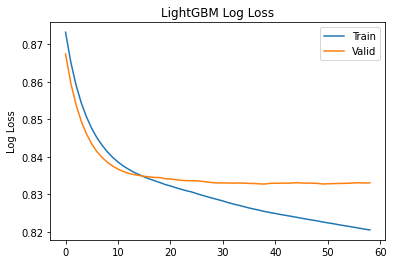

0.8327702863596002

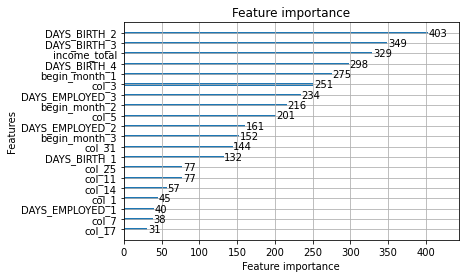

In [ ]:
Some_lightGBM(X_bin,y)

In [ ]:
test_only=test_temp[select_list].reset_index(drop=True)

# pycaret 모델링

In [ ]:
!pip install pycaret

In [ ]:
from pycaret.classification import *
from sklearn.metrics import log_loss


In [ ]:

#clf = setup(concat_train, target = 'credit', train_size = 0.8)

In [ ]:
#add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

In [ ]:
#best2 = compare_models(fold = 2, sort = 'logloss', n_select = 2, exclude=['svm','ridge'])

In [ ]:

clf = setup(train_non, target = 'credit', train_size = 0.8)

,Description,Value
0,session_id,4683
1,Target,credit
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(26457, 6)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

Name                                                           LogLoss
Display Name                                                   LogLoss
Score Function                   <function log_loss at 0x7fade8414f80>
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: logloss, dtype: object

In [ ]:
best3 = compare_models(fold = 2, sort = 'logloss', n_select = 3, exclude=['svm','ridge'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
gbc,Gradient Boosting Classifier,0.6710,0.6150,0.4105,0.5996,0.6005,0.2021,0.2422,0.8429,2.300
lightgbm,Light Gradient Boosting Machine,0.6676,0.6236,0.4070,0.5986,0.5973,0.1924,0.2319,0.8502,0.880
catboost,CatBoost Classifier,0.6601,0.6287,0.4057,0.5903,0.5945,0.1835,0.2162,0.8601,8.000
lr,Logistic Regression,0.6413,0.6058,0.3352,0.5148,0.5044,0.0061,0.0337,0.8646,3.590
lda,Linear Discriminant Analysis,0.6412,0.6054,0.3352,0.5112,0.5045,0.0062,0.0326,0.8649,0.165
ada,Ada Boost Classifier,0.6714,0.6094,0.4100,0.5815,0.6002,0.2021,0.2428,1.0878,0.535
rf,Random Forest Classifier,0.6382,0.6113,0.4110,0.5787,0.5915,0.1759,0.1910,1.8553,1.415
nb,Naive Bayes,0.3871,0.5611,0.3510,0.5163,0.3283,0.0385,0.0418,3.4911,0.130
et,Extra Trees Classifier,0.6182,0.6036,0.4095,0.5679,0.5838,0.1647,0.1722,3.9302,1.450
dt,Decision Tree Classifier,0.6125,0.6017,0.4110,0.5669,0.5824,0.1639,0.1696,4.8289,0.140


In [ ]:
tuned_best3 = [tune_model(i, optimize='logloss') for i in best3]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6604,0.6359,0.3974,0.5942,0.5873,0.1718,0.2085,0.8422
1,0.6802,0.6418,0.4215,0.6304,0.6120,0.2262,0.2695,0.8331
2,0.6812,0.6523,0.4203,0.6433,0.6110,0.2250,0.2708,0.8270
3,0.6684,0.6383,0.4076,0.6259,0.5971,0.1942,0.2343,0.8365
4,0.6641,0.6433,0.4035,0.5903,0.5929,0.1861,0.2231,0.8343
5,0.6744,0.6479,0.4125,0.6454,0.6031,0.2058,0.2501,0.8315
6,0.6649,0.6136,0.4038,0.5839,0.5934,0.1840,0.2228,0.8534
7,0.6734,0.6257,0.4101,0.6222,0.6009,0.1998,0.2456,0.8349
8,0.6668,0.6387,0.4069,0.5842,0.5965,0.1909,0.2296,0.8386
9,0.6725,0.6369,0.4077,0.6223,0.5990,0.1965,0.2425,0.8369


In [ ]:
blend_best3 = blend_models(estimator_list=tuned_best3, fold=5, optimize='logloss')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6707,0.6323,0.4095,0.5680,0.5995,0.2009,0.2408,0.8354
1,0.6740,0.6420,0.4118,0.5723,0.6024,0.2071,0.2496,0.8287
2,0.6735,0.6469,0.4105,0.6929,0.6012,0.2044,0.2475,0.8305
3,0.6707,0.6150,0.4095,0.6906,0.5991,0.1989,0.2402,0.8393
4,0.6716,0.6297,0.4091,0.6304,0.5994,0.1998,0.2423,0.8357
Mean,0.6721,0.6332,0.4101,0.6308,0.6003,0.2022,0.2441,0.8339
SD,0.0014,0.0111,0.0010,0.0544,0.0013,0.0031,0.0038,0.0038


In [ ]:
pred = predict_model(blend_best3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,Voting Classifier,0.6784,0,0.4129,0.578,0.6064,0.2106,0.2557,0


In [ ]:
final_model = finalize_model(blend_best3)
prep_pipe = get_config('prep_pipe')
prep_pipe.steps.append(['trained_model', final_model])


In [ ]:
pred = prep_pipe.predict_proba(test_only)

submit.iloc[:, 1:] = pred
submit.head()

NameError: ignored

In [ ]:
submit=copy.deepcopy(submission)
submit.iloc[:, 1:] = pred
submit.head()

,index,0,1,2
0,26457,0.120414,0.161558,0.718028
1,26458,0.101564,0.200318,0.698118
2,26459,0.136929,0.168967,0.694104
3,26460,0.117602,0.164712,0.717686
4,26461,0.090164,0.245894,0.663942


In [ ]:
submit.to_csv('pycaret_5feature_submission.csv', index=False)